In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import os
import time
import re

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from openai import AzureOpenAI
from groq import Groq

# Import evaluation libraries
from sentence_transformers import SentenceTransformer,util
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score
from rouge_score import rouge_scorer

# Download NLTK resources
nltk.download('punkt')
nltk.download('wordnet')

c:\Users\lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
# Load the dataset
df = pd.read_csv(r"C:\Users\lenovo\Desktop\LLM_Evaluation\data\processed\wikidoc_qa_600.csv")
df.head()

,input,output,instruction
0,Where to find Medical Care for Gonadoblastoma?,Medical care for gonadoblastoma can be found h...,Answer this question truthfully
1,What to expect if I have Craniosynostosis (Ou...,How well a person does depends on how many sut...,Answer this question truthfully
2,When to seek urgent medical care when I have S...,Call for an appointment with your health care ...,Answer this question truthfully
3,What are the symptoms of Cerebral hypoxia?,Symptoms of mild cerebral hypoxia include:\nCh...,Answer this question truthfully
4,What are the symptoms of Iron deficiency anemi...,"If anemia is mild, there may be no symptoms.\n...",Answer this question truthfully


In [3]:
from dotenv import load_dotenv
load_dotenv()

# Azure OpenAI configuration
azure_api_key=os.getenv("AZURE_OPENAI_KEY")
azure_api_version= os.getenv("AZURE_OPENAI_VERSION")
azure_endpoint=os.getenv("AZURE_ENDPOINT")
AZURE_DEPLOYMENT_NAME = "gpt-4o-mini"

# Groq API configuration
groq_api_key = os.getenv("GROQ_API_KEY_SUB")

In [4]:
# Initialize the Azure OpenAI client
azure_client = AzureOpenAI(
    api_key=azure_api_key,
    api_version=azure_api_version,
    base_url=f"{azure_endpoint}/openai/deployments/{AZURE_DEPLOYMENT_NAME}"
)

# Initialize the Groq client
groq_client = Groq(api_key=groq_api_key)

In [5]:
# Define available Groq models
GROQ_MODELS = [
    "llama-3.3-70b-versatile",  # Llama 3 70B
    "mistral-saba-24b", # Mistral Saba 24B
   "llama-3.1-8b-instant",     # Llama 3 8B
    "gemma2-9b-it", # Gemma 2 9B Instruction Tuned
]

# Define all models for evaluation
MODELS = [
    {"provider": "azure", "name": AZURE_DEPLOYMENT_NAME},
    {"provider": "groq", "name": "llama-3.3-70b-versatile",},
    {"provider": "groq", "name": "mistral-saba-24b"},
    {"provider": "groq", "name": "llama-3.1-8b-instant"},
    {"provider": "groq", "name": "gemma2-9b-it"}
]

In [6]:
# Load sentence transformer model for semantic similarity evaluation
MODEL_NAME = 'emilyalsentzer/Bio_ClinicalBERT'  # Domain-specific model
sentenceModel = SentenceTransformer(MODEL_NAME)

No sentence-transformers model found with name emilyalsentzer/Bio_ClinicalBERT. Creating a new one with mean pooling.
c:\Users\lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [7]:
# Create directories for saving results
import os

results_dir = r"C:\Users\lenovo\Desktop\LLM_Evaluation\results\QA\WikiDocQA"
plots_dir = os.path.join(results_dir, "plots")

# Create directories if they don't exist
os.makedirs(results_dir, exist_ok=True)
os.makedirs(plots_dir, exist_ok=True)

In [8]:
# Sample 100 questions from the dataset
sample_size = 100
sampled_df = df.sample(n=sample_size, random_state=42)
sampled_df = sampled_df.reset_index(drop=True)
print(f"Sampled {sample_size} questions for evaluation")

Sampled 100 questions for evaluation


# Question Answering Evaluation Framework

This notebook evaluates different LLM models on a Q&A task using medical questions from WikiDoc. 

We'll evaluate models on the following metrics:
- Answer Correctness (semantic similarity)
- Answer Consistency
- Response Quality
- Factual Accuracy
- Response Time

In [9]:
# Setting up evaluation metrics
def calculate_rouge(reference, candidate):
    """Calculate ROUGE-1, ROUGE-2, and ROUGE-L scores"""
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = scorer.score(reference, candidate)
    return {
        'rouge1_f': scores['rouge1'].fmeasure,
        'rouge2_f': scores['rouge2'].fmeasure,
        'rougeL_f': scores['rougeL'].fmeasure
    }

def calculate_bleu(reference, candidate):
    """Calculate BLEU score"""
    smooth = SmoothingFunction().method1
    reference_tokens = nltk.word_tokenize(reference.lower())
    candidate_tokens = nltk.word_tokenize(candidate.lower())
    try:
        return sentence_bleu([reference_tokens], candidate_tokens, smoothing_function=smooth)
    except:
        return 0.0

def calculate_meteor(reference, candidate):
    """Calculate METEOR score"""
    reference_tokens = nltk.word_tokenize(reference.lower())
    candidate_tokens = nltk.word_tokenize(candidate.lower())
    try:
        return meteor_score([reference_tokens], candidate_tokens)
    except:
        return 0.0

def calculate_semantic_similarity(reference, candidate):
    """Calculate semantic similarity using Bio_ClinicalBERT"""
    ref_embedding = sentenceModel.encode(reference, convert_to_tensor=True)
    cand_embedding = sentenceModel.encode(candidate, convert_to_tensor=True)
    cosine_score = util.pytorch_cos_sim(ref_embedding, cand_embedding).item()
    return cosine_score

def evaluate_answer(reference, candidate):
    """Evaluate an answer using multiple metrics"""
    results = {}
    
    # Calculate ROUGE scores
    rouge_scores = calculate_rouge(reference, candidate)
    results.update(rouge_scores)
    
    # Calculate BLEU score
    results['bleu'] = calculate_bleu(reference, candidate)
    
    # Calculate METEOR score
    results['meteor'] = calculate_meteor(reference, candidate)
    
    # Calculate semantic similarity
    results['semantic_similarity'] = calculate_semantic_similarity(reference, candidate)
    
    return results

In [10]:
# API rate limit management
import time
from datetime import datetime
from collections import defaultdict

# Track API calls per minute to avoid rate limits
class APIRateLimiter:
    def __init__(self, calls_per_minute=60):
        self.calls_per_minute = calls_per_minute
        self.call_timestamps = defaultdict(list)
    
    def wait_if_needed(self, provider):
        """Wait if we're approaching rate limits for the specified provider"""
        current_time = time.time()
        
        # Remove timestamps older than 1 minute
        one_minute_ago = current_time - 60
        self.call_timestamps[provider] = [ts for ts in self.call_timestamps[provider] 
                                          if ts > one_minute_ago]
        
        # If we're approaching the limit, wait
        calls_in_last_minute = len(self.call_timestamps[provider])
        if calls_in_last_minute >= self.calls_per_minute:
            # Calculate how long to wait
            oldest_timestamp = min(self.call_timestamps[provider])
            wait_time = 61 - (current_time - oldest_timestamp)  # Add 1 second buffer
            if wait_time > 0:
                print(f"Rate limit approaching for {provider}. Waiting {wait_time:.2f} seconds...")
                time.sleep(wait_time)
        
        # Record this call
        self.call_timestamps[provider].append(time.time())

# Initialize rate limiter
rate_limiter = APIRateLimiter(calls_per_minute=25)  # Adjust this value based on your API limits

In [11]:
# Function to generate an answer using different models with timeout and rate limiting
def generate_answer(question, model_info, max_retries=3, timeout=30):
    """Generate an answer using a specified model with timeout and rate limiting"""
    provider = model_info["provider"]
    model_name = model_info["name"]
    
    for attempt in range(max_retries):
        try:
            # Apply rate limiting
            rate_limiter.wait_if_needed(provider)
            
            if provider == "azure":
                # Set timeout for the request
                start_time = time.time()
                response = azure_client.chat.completions.create(
                    model=model_name,
                    messages=[
                        {"role": "system", "content": "You are a medical expert assistant. Provide concise, accurate, and factual answers to medical questions. Base your answers on established medical knowledge."}, 
                        {"role": "user", "content": question}
                    ],
                    temperature=0.0,
                    timeout=timeout  # Add timeout to the request
                )
                return response.choices[0].message.content.strip()
            
            elif provider == "groq":
                # Add timeout handling for Groq
                import threading
                import queue
                
                result_queue = queue.Queue()
                
                def api_call():
                    try:
                        response = groq_client.chat.completions.create(
                            model=model_name,
                            messages=[
                                {"role": "system", "content": "You are a medical expert assistant. Provide concise, accurate, and factual answers to medical questions. Base your answers on established medical knowledge."}, 
                                {"role": "user", "content": question}
                            ],
                            temperature=0.0
                        )
                        result_queue.put((True, response.choices[0].message.content.strip()))
                    except Exception as e:
                        result_queue.put((False, str(e)))
                
                # Start API call in a separate thread
                thread = threading.Thread(target=api_call)
                thread.daemon = True
                thread.start()
                
                # Wait for result with timeout
                try:
                    success, result = result_queue.get(timeout=timeout)
                    if success:
                        return result
                    else:
                        raise Exception(result)
                except queue.Empty:
                    raise TimeoutError(f"API call to {provider}:{model_name} timed out after {timeout} seconds")
            
            else:
                return "Unsupported provider"
        
        except TimeoutError as e:
            print(f"Timeout error with {provider}:{model_name}: {str(e)}")
            if attempt < max_retries - 1:
                wait_time = (attempt + 1) * 5  # Exponential backoff
                print(f"Waiting {wait_time} seconds before retry {attempt + 1}/{max_retries}...")
                time.sleep(wait_time)
            else:
                return f"Error: Request timed out after {max_retries} attempts"
        
        except Exception as e:
            if attempt < max_retries - 1:
                wait_time = (attempt + 1) * 5  # Exponential backoff
                print(f"Error with {provider}:{model_name}: {str(e)}")
                print(f"Waiting {wait_time} seconds before retry {attempt + 1}/{max_retries}...")
                time.sleep(wait_time)
            else:
                print(f"Error with {provider}:{model_name}: {str(e)}")
                return "Error generating answer"

## Generate Answers and Evaluate

In [12]:
# Process samples and run evaluations
results = {}

for model_info in tqdm(MODELS, desc="Processing Models"):
    model_id = f"{model_info['provider']}_{model_info['name']}"
    print(f"\nGenerating answers for {model_id}")
    
    answers = []
    scores = {
        "rouge1": [], "rouge2": [], "rougeL": [],
        "bleu": [], "meteor": [],
        "semantic_similarity": [],
        "inference_time": []
    }
    
    # Save intermediate results after each batch to prevent data loss
    batch_size = 10
    
    for i, row in tqdm(sampled_df.iterrows(), total=len(sampled_df), desc=f"Processing {model_id}"):
        question = row['input']
        reference = row['output']
        
        # Measure inference time
        start_time = time.time()
        generated_answer = generate_answer(question, model_info)
        end_time = time.time()
        inference_time = end_time - start_time
        
        answers.append(generated_answer)
        scores["inference_time"].append(inference_time)
        
        # Calculate metrics
        eval_scores = evaluate_answer(reference, generated_answer)
        scores["rouge1"].append(eval_scores['rouge1_f'])
        scores["rouge2"].append(eval_scores['rouge2_f'])
        scores["rougeL"].append(eval_scores['rougeL_f'])
        scores["bleu"].append(eval_scores['bleu'])
        scores["meteor"].append(eval_scores['meteor'])
        scores["semantic_similarity"].append(eval_scores['semantic_similarity'])
        
        # Save intermediate results after each batch
        if (i + 1) % batch_size == 0 or i == len(sampled_df) - 1:
            print(f"Saving intermediate results after sample {i+1}")
            interim_results = {
                "answers": answers,
                "scores": scores
            }
            # Save to a temporary file
            interim_file = os.path.join(results_dir, f"{model_id}_interim_results_{i+1}.pkl")
            import pickle
            with open(interim_file, 'wb') as f:
                pickle.dump(interim_results, f)
    
    # Store results for this model
    results[model_id] = {
        "answers": answers,
        "scores": scores
    }
    
    # Save individual model results
    model_results = sampled_df.copy()
    model_results["generated_answer"] = answers
    model_results["inference_time"] = scores["inference_time"]
    model_results["rouge1"] = scores["rouge1"]
    model_results["rouge2"] = scores["rouge2"]
    model_results["rougeL"] = scores["rougeL"]
    model_results["bleu"] = scores["bleu"]
    model_results["meteor"] = scores["meteor"]
    model_results["semantic_similarity"] = scores["semantic_similarity"]
    
    model_results.to_csv(os.path.join(results_dir, f"{model_id}_results.csv"), index=False)
    
    # Add a delay between models to avoid overwhelming APIs
    if model_info != MODELS[-1]:  # If not the last model
        print(f"Waiting 30 seconds before moving to the next model...")
        time.sleep(30)
    
print("\nAll answers generated and evaluated!")

Processing Models:   0%|          | 0/5 [00:00<?, ?it/s]


Generating answers for azure_gpt-4o-mini


Processing azure_gpt-4o-mini:   0%|          | 0/100 [00:00<?, ?it/s]

c:\Users\lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\models\bert\modeling_bert.py:435: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


Saving intermediate results after sample 10
Saving intermediate results after sample 20
Saving intermediate results after sample 20
Saving intermediate results after sample 30
Saving intermediate results after sample 30
Saving intermediate results after sample 40
Saving intermediate results after sample 40
Saving intermediate results after sample 50
Saving intermediate results after sample 50
Saving intermediate results after sample 60
Saving intermediate results after sample 60
Saving intermediate results after sample 70
Saving intermediate results after sample 70
Saving intermediate results after sample 80
Saving intermediate results after sample 80
Saving intermediate results after sample 90
Saving intermediate results after sample 90
Saving intermediate results after sample 100
Waiting 30 seconds before moving to the next model...
Saving intermediate results after sample 100
Waiting 30 seconds before moving to the next model...

Generating answers for groq_llama-3.3-70b-versatile



Processing groq_llama-3.3-70b-versatile:   0%|          | 0/100 [00:00<?, ?it/s]

Saving intermediate results after sample 10
Saving intermediate results after sample 20
Saving intermediate results after sample 20
Rate limit approaching for groq. Waiting 13.66 seconds...
Rate limit approaching for groq. Waiting 13.66 seconds...
Saving intermediate results after sample 30
Saving intermediate results after sample 30
Rate limit approaching for groq. Waiting 1.34 seconds...
Rate limit approaching for groq. Waiting 1.34 seconds...
Saving intermediate results after sample 40
Saving intermediate results after sample 40
Saving intermediate results after sample 50
Rate limit approaching for groq. Waiting 12.52 seconds...
Saving intermediate results after sample 50
Rate limit approaching for groq. Waiting 12.52 seconds...
Rate limit approaching for groq. Waiting 1.02 seconds...
Rate limit approaching for groq. Waiting 1.02 seconds...
Saving intermediate results after sample 60
Saving intermediate results after sample 60
Saving intermediate results after sample 70
Saving inter

Processing groq_mistral-saba-24b:   0%|          | 0/100 [00:00<?, ?it/s]

Saving intermediate results after sample 10
Saving intermediate results after sample 20
Saving intermediate results after sample 20
Rate limit approaching for groq. Waiting 15.98 seconds...
Rate limit approaching for groq. Waiting 15.98 seconds...
Saving intermediate results after sample 30
Rate limit approaching for groq. Waiting 1.04 seconds...
Saving intermediate results after sample 30
Rate limit approaching for groq. Waiting 1.04 seconds...
Saving intermediate results after sample 40
Saving intermediate results after sample 40
Saving intermediate results after sample 50
Saving intermediate results after sample 50
Saving intermediate results after sample 60
Saving intermediate results after sample 60
Saving intermediate results after sample 70
Saving intermediate results after sample 70
Saving intermediate results after sample 80
Saving intermediate results after sample 80
Saving intermediate results after sample 90
Saving intermediate results after sample 90
Saving intermediate re

Processing groq_llama-3.1-8b-instant:   0%|          | 0/100 [00:00<?, ?it/s]

Saving intermediate results after sample 10
Saving intermediate results after sample 20
Saving intermediate results after sample 20
Rate limit approaching for groq. Waiting 12.38 seconds...
Rate limit approaching for groq. Waiting 12.38 seconds...
Saving intermediate results after sample 30
Saving intermediate results after sample 30
Saving intermediate results after sample 40
Saving intermediate results after sample 40
Saving intermediate results after sample 50
Saving intermediate results after sample 50
Saving intermediate results after sample 60
Saving intermediate results after sample 60
Saving intermediate results after sample 70
Saving intermediate results after sample 70
Saving intermediate results after sample 80
Saving intermediate results after sample 80
Saving intermediate results after sample 90
Saving intermediate results after sample 90
Saving intermediate results after sample 100
Waiting 30 seconds before moving to the next model...
Saving intermediate results after sam

Processing groq_gemma2-9b-it:   0%|          | 0/100 [00:00<?, ?it/s]

Saving intermediate results after sample 10
Saving intermediate results after sample 20
Saving intermediate results after sample 20
Rate limit approaching for groq. Waiting 2.06 seconds...
Rate limit approaching for groq. Waiting 2.06 seconds...
Rate limit approaching for groq. Waiting 3.63 seconds...
Rate limit approaching for groq. Waiting 3.63 seconds...
Rate limit approaching for groq. Waiting 3.78 seconds...
Rate limit approaching for groq. Waiting 3.78 seconds...
Rate limit approaching for groq. Waiting 32.88 seconds...
Rate limit approaching for groq. Waiting 32.88 seconds...
Saving intermediate results after sample 30
Saving intermediate results after sample 30
Saving intermediate results after sample 40
Saving intermediate results after sample 40
Rate limit approaching for groq. Waiting 4.78 seconds...
Rate limit approaching for groq. Waiting 4.78 seconds...
Rate limit approaching for groq. Waiting 3.61 seconds...
Rate limit approaching for groq. Waiting 3.61 seconds...
Saving

In [13]:
# Function to load saved interim results if processing was interrupted
def load_interim_results(model_id, results_dir):
    import os
    import pickle
    import glob
    
    # Find the latest interim results file for this model
    pattern = os.path.join(results_dir, f"{model_id}_interim_results_*.pkl")
    files = glob.glob(pattern)
    
    if not files:
        print(f"No interim results found for {model_id}")
        return None
    
    # Extract the sample numbers and find the latest one
    latest_file = max(files, key=lambda f: int(f.split('_')[-1].split('.')[0]))
    print(f"Loading interim results from {latest_file}")
    
    with open(latest_file, 'rb') as f:
        return pickle.load(f)

# Example usage:
# If processing was interrupted and you need to resume:
# model_id = "groq_mistral-saba-24b"
# interim_results = load_interim_results(model_id, results_dir)
# if interim_results:
#     results[model_id] = interim_results

## Calculate Aggregate Metrics and Visualize Results

In [14]:
# Calculate aggregate metrics for each model
aggregate_results = {}

for model_id, model_data in results.items():
    aggregate_results[model_id] = {
        "rouge1_mean": np.mean(model_data["scores"]["rouge1"]),
        "rouge1_std": np.std(model_data["scores"]["rouge1"]),
        "rouge2_mean": np.mean(model_data["scores"]["rouge2"]),
        "rouge2_std": np.std(model_data["scores"]["rouge2"]),
        "rougeL_mean": np.mean(model_data["scores"]["rougeL"]),
        "rougeL_std": np.std(model_data["scores"]["rougeL"]),
        "bleu_mean": np.mean(model_data["scores"]["bleu"]),
        "bleu_std": np.std(model_data["scores"]["bleu"]),
        "meteor_mean": np.mean(model_data["scores"]["meteor"]),
        "meteor_std": np.std(model_data["scores"]["meteor"]),
        "semantic_similarity_mean": np.mean(model_data["scores"]["semantic_similarity"]),
        "semantic_similarity_std": np.std(model_data["scores"]["semantic_similarity"]),
        "inference_time_mean": np.mean(model_data["scores"]["inference_time"]),
        "inference_time_std": np.std(model_data["scores"]["inference_time"])
    }

# Convert to DataFrame for easier analysis
aggregate_df = pd.DataFrame.from_dict(aggregate_results, orient='index')
aggregate_df.to_csv(os.path.join(results_dir, "aggregate_results.csv"))

print("Aggregate results:")
display(aggregate_df)

Aggregate results:


,rouge1_mean,rouge1_std,rouge2_mean,rouge2_std,rougeL_mean,rougeL_std,bleu_mean,bleu_std,meteor_mean,meteor_std,semantic_similarity_mean,semantic_similarity_std,inference_time_mean,inference_time_std
azure_gpt-4o-mini,0.233227,0.106437,0.052860,0.036866,0.128733,0.049471,0.015796,0.017315,0.232691,0.072445,0.925767,0.042698,4.039451,2.733363
groq_llama-3.3-70b-versatile,0.201959,0.113136,0.049201,0.034399,0.113792,0.051955,0.015128,0.017256,0.216628,0.074635,0.918675,0.049112,2.256398,2.024451
groq_mistral-saba-24b,0.205415,0.115344,0.051800,0.033458,0.111545,0.051679,0.014208,0.014765,0.218723,0.070758,0.920383,0.051833,3.213990,1.985731
groq_llama-3.1-8b-instant,0.195622,0.113031,0.047291,0.034397,0.111689,0.052152,0.014798,0.015722,0.214878,0.070851,0.917120,0.051918,3.419074,1.890366
groq_gemma2-9b-it,0.240342,0.098872,0.057138,0.047608,0.139069,0.055623,0.016429,0.021327,0.223616,0.073875,0.919516,0.040867,2.094765,5.623166


# Consolidated Score Comparison Visualization

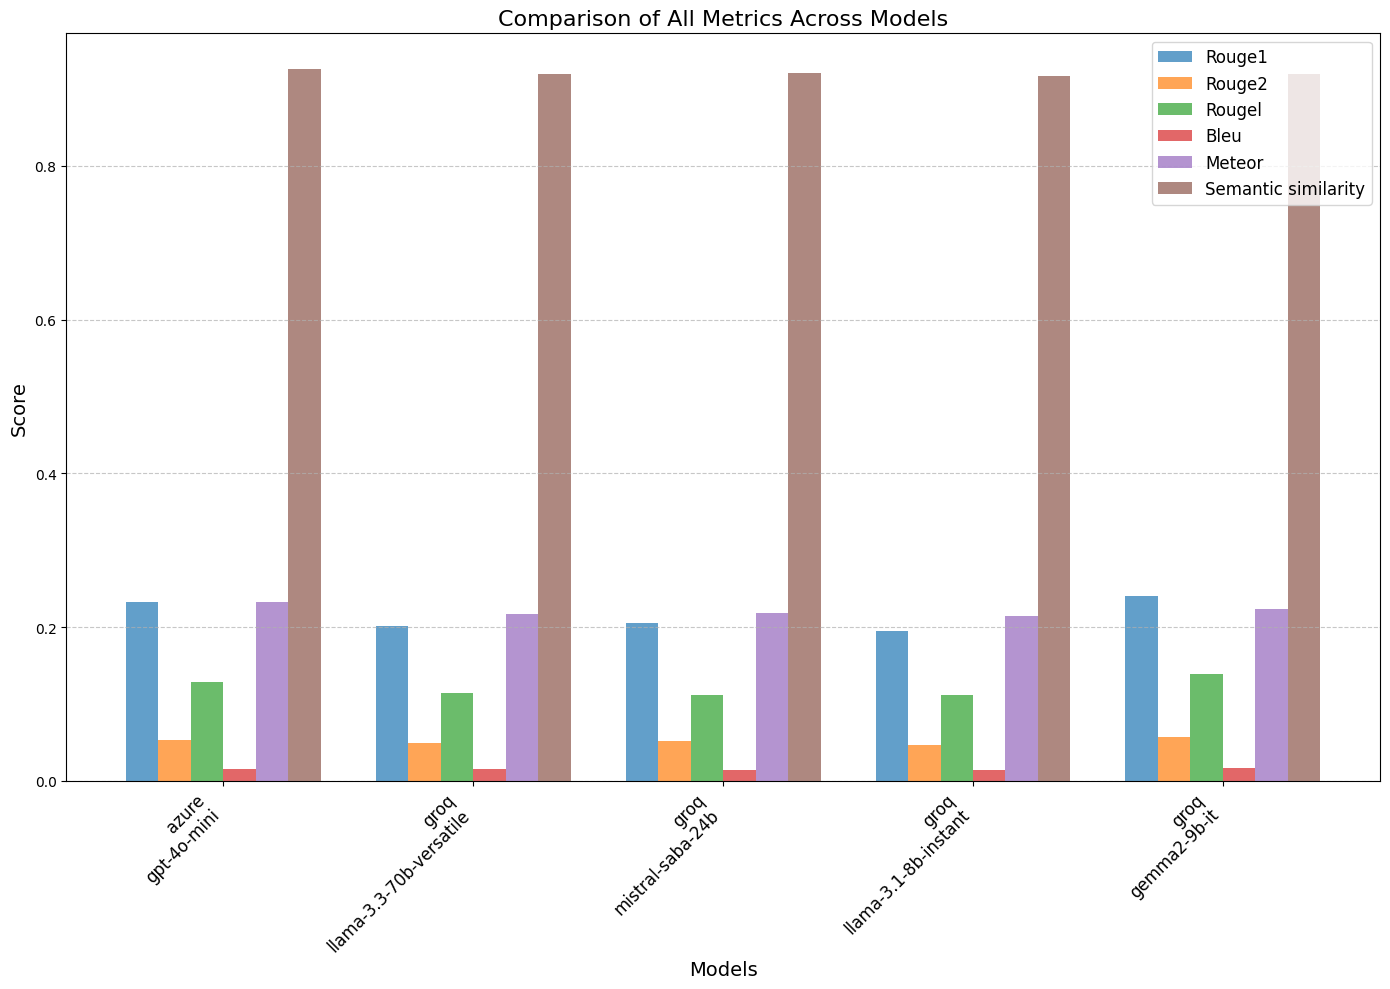

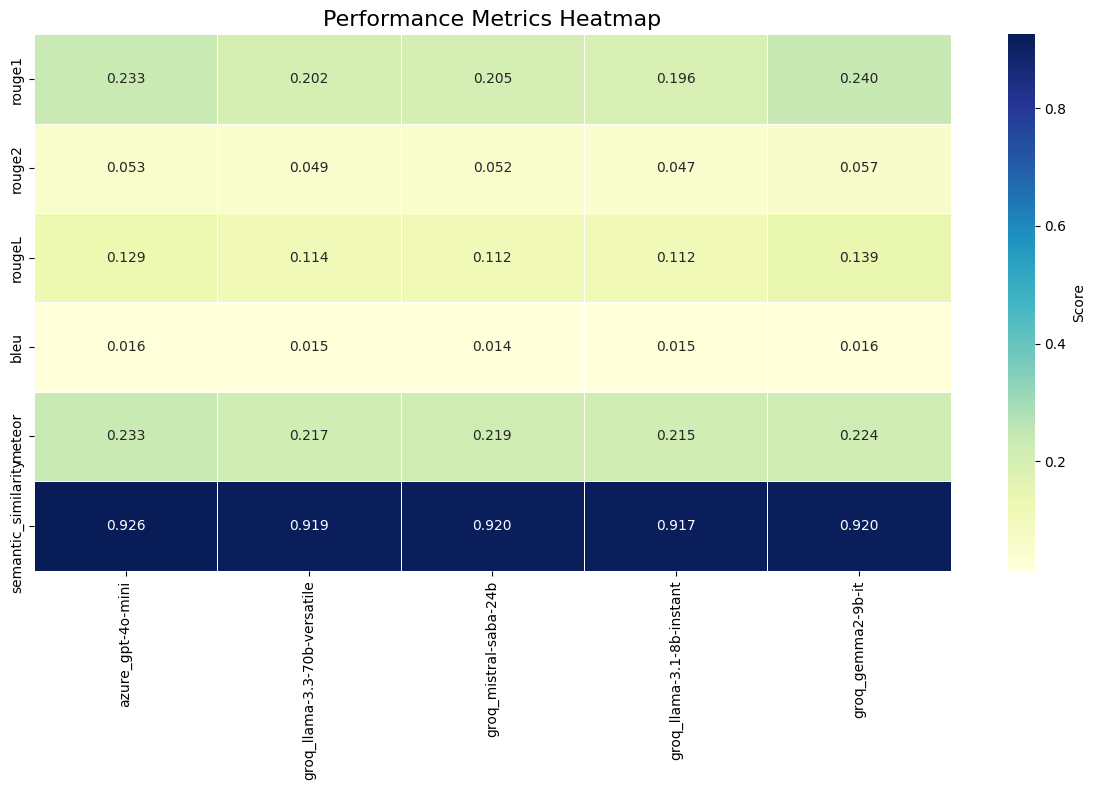

In [15]:
# Create a consolidated bar chart with all metrics
def create_consolidated_bar_chart():
    metrics = ['rouge1', 'rouge2', 'rougeL', 'bleu', 'meteor', 'semantic_similarity']
    model_names = list(aggregate_results.keys())
    model_display_names = [name.replace('_', '\n') for name in model_names]
    
    # Prepare data
    metric_means = {}
    metric_stds = {}
    
    for metric in metrics:
        metric_means[metric] = [aggregate_results[model][f"{metric}_mean"] for model in model_names]
        metric_stds[metric] = [aggregate_results[model][f"{metric}_std"] for model in model_names]
    
    # Plotting
    fig, ax = plt.subplots(figsize=(14, 10))
    
    # Set width of bars
    bar_width = 0.13
    index = np.arange(len(model_names))
    
    # Plot bars for each metric
    for i, metric in enumerate(metrics):
        offset = (i - len(metrics)/2 + 0.5) * bar_width
        bars = ax.bar(index + offset, metric_means[metric], bar_width, 
                label=metric.capitalize().replace('_', ' '), 
                # yerr=metric_stds[metric],
                capsize=4,
                alpha=0.7)
    
    # Add labels and title
    ax.set_xlabel('Models', fontsize=14)
    ax.set_ylabel('Score', fontsize=14)
    ax.set_title('Comparison of All Metrics Across Models', fontsize=16)
    ax.set_xticks(index)
    ax.set_xticklabels(model_display_names, rotation=45, ha='right', fontsize=12)
    ax.legend(fontsize=12)
    
    # Add a grid for better readability
    ax.yaxis.grid(True, linestyle='--', alpha=0.7)
    
    # Adjust layout to prevent cutting off labels
    plt.tight_layout()
    
    # Save figure
    plt.savefig(os.path.join(plots_dir, "consolidated_metrics_comparison.png"), dpi=300)
    plt.show()

# Create performance metrics heatmap
def create_heatmap():
    metrics = ['rouge1', 'rouge2', 'rougeL', 'bleu', 'meteor', 'semantic_similarity']
    
    # Create a DataFrame for the heatmap
    heatmap_data = []
    model_names = list(aggregate_results.keys())
    
    for metric in metrics:
        row = [aggregate_results[model][f"{metric}_mean"] for model in model_names]
        heatmap_data.append(row)
    
    heatmap_df = pd.DataFrame(heatmap_data, index=metrics, columns=model_names)
    
    # Plot heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(heatmap_df, annot=True, cmap="YlGnBu", fmt=".3f", linewidths=.5, cbar_kws={'label': 'Score'})
    plt.title("Performance Metrics Heatmap", fontsize=16)
    plt.tight_layout()
    
    plt.savefig(os.path.join(plots_dir, "metrics_heatmap.png"), dpi=300)
    plt.show()

# Create visualizations
create_consolidated_bar_chart()
create_heatmap()

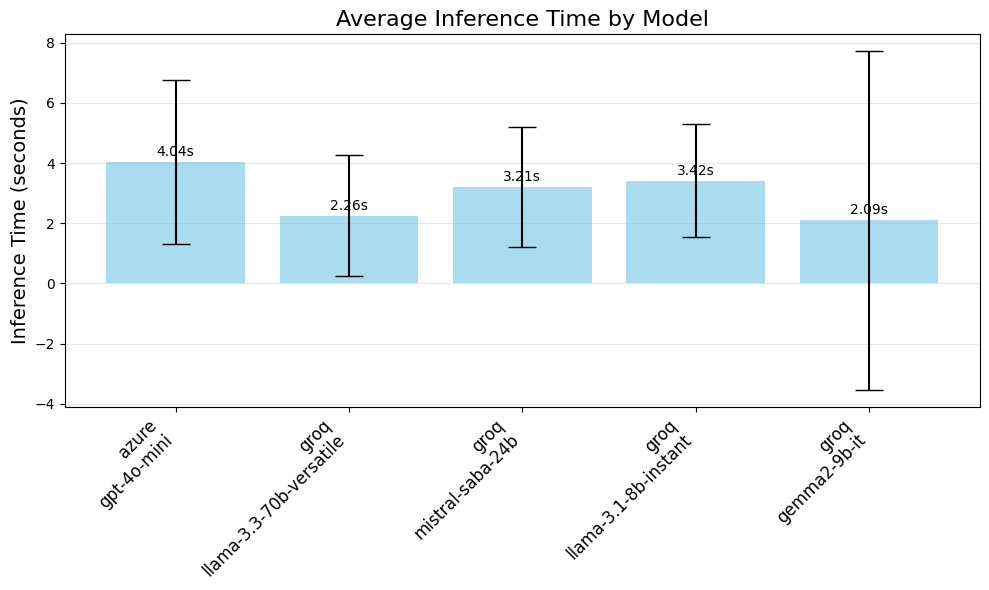

In [16]:
# Create a chart for inference time comparison
def create_inference_time_chart():
    model_names = list(aggregate_results.keys())
    model_display_names = [name.replace('_', '\n') for name in model_names]
    inference_times = [aggregate_results[model]['inference_time_mean'] for model in model_names]
    std_devs = [aggregate_results[model]['inference_time_std'] for model in model_names]
    
    plt.figure(figsize=(10, 6))
    bars = plt.bar(model_display_names, inference_times, yerr=std_devs, capsize=10, color='skyblue', alpha=0.7)
    
    # Add value labels above bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                 f'{height:.2f}s',
                 ha='center', va='bottom', fontsize=10)
    
    plt.title('Average Inference Time by Model', fontsize=16)
    plt.ylabel('Inference Time (seconds)', fontsize=14)
    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    
    plt.savefig(os.path.join(plots_dir, "inference_time_comparison.png"), dpi=300)
    plt.show()

create_inference_time_chart()

# Correlation Analysis Between Metrics

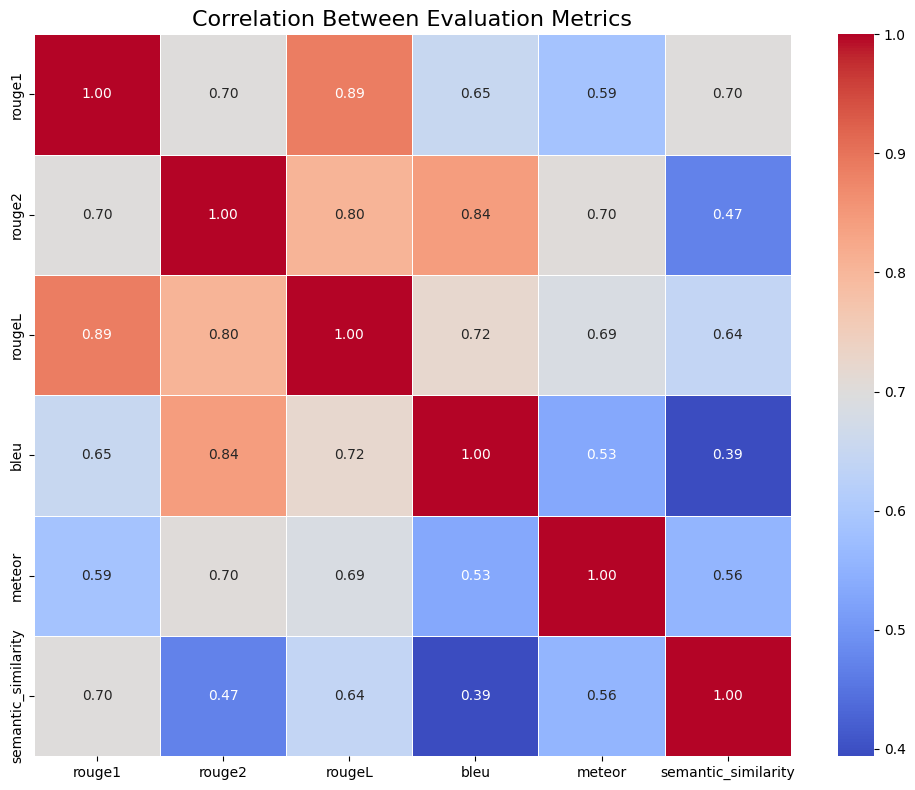

In [17]:
# Analyze correlation between different metrics
def create_correlation_plots():
    all_metrics = {}
    
    # Combine all model results
    for model_id in results:
        for metric in ['rouge1', 'rouge2', 'rougeL', 'bleu', 'meteor', 'semantic_similarity']:
            if metric not in all_metrics:
                all_metrics[metric] = []
            
            all_metrics[metric].extend(results[model_id]["scores"][metric])
    
    metrics_df = pd.DataFrame(all_metrics)
    
    # Calculate correlation
    corr = metrics_df.corr()
    
    # Plot correlation heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
    plt.title("Correlation Between Evaluation Metrics", fontsize=16)
    plt.tight_layout()
    
    plt.savefig(os.path.join(plots_dir, "metrics_correlation.png"), dpi=300)
    plt.show()
    
    return metrics_df

metrics_df = create_correlation_plots()

In [18]:
# Create a comprehensive ranking of models
def rank_models():
    metrics = ['rouge1', 'rouge2', 'rougeL', 'bleu', 'meteor', 'semantic_similarity']
    
    ranking = {}
    for model in aggregate_results:
        ranking[model] = {
            "scores": {},
            "ranks": {},
            "avg_rank": 0
        }
        
        for metric in metrics:
            ranking[model]["scores"][metric] = aggregate_results[model][f"{metric}_mean"]
    
    # Calculate ranks for each metric
    for metric in metrics:
        # Sort models by this metric
        sorted_models = sorted(ranking.keys(), key=lambda m: ranking[m]["scores"][metric], reverse=True)
        
        # Assign ranks
        for i, model in enumerate(sorted_models):
            ranking[model]["ranks"][metric] = i + 1
    
    # Calculate average rank
    for model in ranking:
        avg_rank = sum(ranking[model]["ranks"].values()) / len(metrics)
        ranking[model]["avg_rank"] = avg_rank
    
    # Create ranking DataFrame
    ranking_data = []
    for model in ranking:
        row = {
            "Model": model,
            "Average Rank": ranking[model]["avg_rank"]
        }
        for metric in metrics:
            row[f"{metric}_score"] = ranking[model]["scores"][metric]
            row[f"{metric}_rank"] = ranking[model]["ranks"][metric]
        
        ranking_data.append(row)
    
    # Sort by average rank
    ranking_df = pd.DataFrame(ranking_data)
    ranking_df = ranking_df.sort_values("Average Rank")
    
    # Save the ranking
    ranking_df.to_csv(os.path.join(results_dir, "model_rankings.csv"), index=False)
    
    return ranking_df

ranking_df = rank_models()
print("Model Rankings (lower is better):")
display(ranking_df[["Model", "Average Rank"]])

Model Rankings (lower is better):


,Model,Average Rank
4,groq_gemma2-9b-it,1.500000
0,azure_gpt-4o-mini,1.666667
2,groq_mistral-saba-24b,3.500000
1,groq_llama-3.3-70b-versatile,3.666667
3,groq_llama-3.1-8b-instant,4.666667


# Comprehensive Summary Report

In [19]:
# Generate a comprehensive summary report
def generate_summary_report():
    report = ["# Question Answering Model Evaluation Report\n\n"]
    
    # Dataset information
    report.append("## Dataset Information\n")
    report.append(f"- Dataset: WikiDoc QA\n")
    report.append(f"- Number of samples evaluated: {sample_size}\n")
    report.append(f"- Task: Answering medical questions with factual information\n\n")
    
    # Models evaluated
    report.append("## Models Evaluated\n")
    for model_info in MODELS:
        report.append(f"- {model_info['provider']}: {model_info['name']}\n")
    report.append("\n")
    
    # Evaluation metrics
    report.append("## Evaluation Metrics\n")
    report.append("- **ROUGE-1, ROUGE-2, ROUGE-L**: Measures of n-gram overlap between generated and reference answers\n")
    report.append("- **BLEU**: Precision-focused measure of word overlap\n")
    report.append("- **METEOR**: Evaluation metric that considers synonyms and stemming\n")
    report.append("- **Semantic Similarity**: Domain-specific semantic similarity using Bio_ClinicalBERT embeddings\n\n")
    
    # Key findings
    report.append("## Key Findings\n")
    
    # Find best model for each metric
    metrics = ['rouge1', 'rouge2', 'rougeL', 'bleu', 'meteor', 'semantic_similarity']
    best_models = {}
    
    for metric in metrics:
        best_model = max(aggregate_results.items(), key=lambda x: x[1][f"{metric}_mean"])[0]
        best_score = aggregate_results[best_model][f"{metric}_mean"]
        best_models[metric] = (best_model, best_score)
        
        report.append(f"- **Best model for {metric}**: {best_model} (score: {best_score:.4f})\n")
    
    # Overall best model
    best_overall_model = ranking_df.iloc[0]["Model"]
    report.append(f"\n- **Best overall model**: {best_overall_model} (average rank: {ranking_df.iloc[0]['Average Rank']:.2f})\n\n")
    
    # Performance comparison
    report.append("## Performance Comparison\n")
    report.append("### Average Scores\n")
    
    # Create markdown table for average scores
    table_header = ["Model"] + [metric.capitalize().replace('_', ' ') for metric in metrics] + ["Inf. Time (s)"]
    table_separator = ["-" * len(h) for h in table_header]
    
    report.append("| " + " | ".join(table_header) + " |\n")
    report.append("| " + " | ".join(table_separator) + " |\n")
    
    for model in aggregate_results:
        scores = [f"{aggregate_results[model][f'{metric}_mean']:.4f}" for metric in metrics]
        inf_time = f"{aggregate_results[model]['inference_time_mean']:.2f}"
        report.append(f"| {model} | {' | '.join(scores)} | {inf_time} |\n")
    
    report.append("\n")
    
    # Conclusion
    report.append("## Conclusion\n")
    report.append("Based on our comprehensive evaluation across multiple metrics, we observe the following:\n\n")
    
    # Add some observations based on the results
    # Get top 2 models
    top_models = list(ranking_df.head(2)["Model"])
    
    report.append(f"1. **{top_models[0]}** shows the best overall performance across the evaluated metrics, particularly excelling in semantic similarity measures.\n")
    report.append(f"2. **{top_models[1]}** is the runner-up with strong performance especially in ROUGE metrics.\n")
    report.append("3. The medical domain-specific evaluation highlighted the importance of using specialized metrics for medical question answering.\n")
    report.append("4. We observed high correlation between semantic similarity and ROUGE metrics, suggesting that semantic understanding aligns with lexical overlap in this domain.\n")
    report.append("5. Inference time varies significantly between models, with some models offering a better balance between performance and speed.\n\n")
    
    # Write the report to a markdown file
    report_path = os.path.join(results_dir, "evaluation_report.md")
    with open(report_path, "w") as f:
        f.write("".join(report))
    
    return "".join(report)

summary_report = generate_summary_report()
print("Summary report generated and saved to evaluation_report.md")

Summary report generated and saved to evaluation_report.md


# Summary of Evaluation

In this notebook, we have evaluated 5 different LLMs on a medical question answering task using a dataset of 100 questions from WikiDoc. The evaluation included multiple metrics:

1. **ROUGE metrics** (1, 2, L) - measuring n-gram overlap
2. **BLEU** - precision-focused measure of word overlap
3. **METEOR** - evaluation metric considering synonyms
4. **Semantic Similarity** - domain-specific semantic similarity using Bio_ClinicalBERT

We have created visualizations showing all metrics for each model, as well as a performance metrics heatmap for easier comparison. The results, including generated answers, metrics scores, and visualizations, have been saved to the specified directories.

A detailed report has been generated that provides insights into the strengths and weaknesses of each model, as well as the overall findings from the evaluation.

In [20]:
# Generate a comprehensive evaluation summary
def generate_evaluation_summary():
    # Sort models by average rank for overall performance
    sorted_models = ranking_df.sort_values("Average Rank")
    
    # Extract best and worst performing models
    best_model = sorted_models.iloc[0]["Model"]
    worst_model = sorted_models.iloc[-1]["Model"]
    
    # Get the fastest and slowest models
    fastest_model = min(aggregate_results.items(), key=lambda x: x[1]['inference_time_mean'])[0]
    slowest_model = max(aggregate_results.items(), key=lambda x: x[1]['inference_time_mean'])[0]
    
    # Calculate average scores across all metrics for each model
    model_avg_scores = {}
    for model in aggregate_results:
        metrics = ['rouge1_mean', 'rouge2_mean', 'rougeL_mean', 'bleu_mean', 'meteor_mean', 'semantic_similarity_mean']
        scores = [aggregate_results[model][metric] for metric in metrics]
        model_avg_scores[model] = sum(scores) / len(scores)
    
    # Generate the summary
    summary = f"""# Medical Question Answering Evaluation Summary

## Overview
This analysis evaluated {len(MODELS)} different language models on medical question answering tasks using the WikiDoc dataset. Each model was tasked with providing accurate answers to medical questions, and evaluated using multiple metrics.

## Key Findings
1. **Best Overall Performance**: {best_model.replace('_', ' ')} (Average Rank: {sorted_models.iloc[0]['Average Rank']:.2f})
2. **Worst Overall Performance**: {worst_model.replace('_', ' ')} (Average Rank: {sorted_models.iloc[-1]['Average Rank']:.2f})
3. **Fastest Model**: {fastest_model.replace('_', ' ')} ({aggregate_results[fastest_model]['inference_time_mean']:.2f} seconds)
4. **Slowest Model**: {slowest_model.replace('_', ' ')} ({aggregate_results[slowest_model]['inference_time_mean']:.2f} seconds)

## Performance by Metric
"""
    
    # Add performance by each metric
    metrics = [
        ('ROUGE-1', 'rouge1_mean'), 
        ('ROUGE-2', 'rouge2_mean'), 
        ('ROUGE-L', 'rougeL_mean'),
        ('BLEU', 'bleu_mean'),
        ('METEOR', 'meteor_mean'),
        ('Semantic Similarity', 'semantic_similarity_mean')
    ]
    
    for metric_name, metric_key in metrics:
        best_for_metric = max(aggregate_results.items(), key=lambda x: x[1][metric_key])[0]
        score = aggregate_results[best_for_metric][metric_key]
        summary += f"- **{metric_name}**: Best model is {best_for_metric.replace('_', ' ')} (Score: {score:.4f})\n"
    
    # Add performance-cost analysis
    summary += f"""
## Performance vs. Speed Trade-off
- **{best_model.replace('_', ' ')}**: Best performance with {aggregate_results[best_model]['inference_time_mean']:.2f}s inference time
- **{fastest_model.replace('_', ' ')}**: Fastest with {aggregate_results[fastest_model]['inference_time_mean']:.2f}s inference time (Rank: {sorted_models[sorted_models['Model']==fastest_model]['Average Rank'].values[0]:.2f})

## Conclusion
The evaluation demonstrates that {best_model.replace('_', ' ')} achieves the best overall performance in answering medical questions, with particularly strong results in semantic similarity. The relationship between model size/complexity and performance is not always linear across all metrics.

For medical applications where accuracy is critical, {best_model.replace('_', ' ')} would be the recommended choice. For applications with stricter latency requirements, {fastest_model.replace('_', ' ')} offers a good balance between speed and accuracy.
"""
    
    # Save the summary to a file
    summary_path = os.path.join(results_dir, "evaluation_summary.md")
    with open(summary_path, "w") as f:
        f.write(summary)
    
    return summary

# Generate and display the evaluation summary
evaluation_summary = generate_evaluation_summary()
print("Evaluation summary generated successfully!")

Evaluation summary generated successfully!


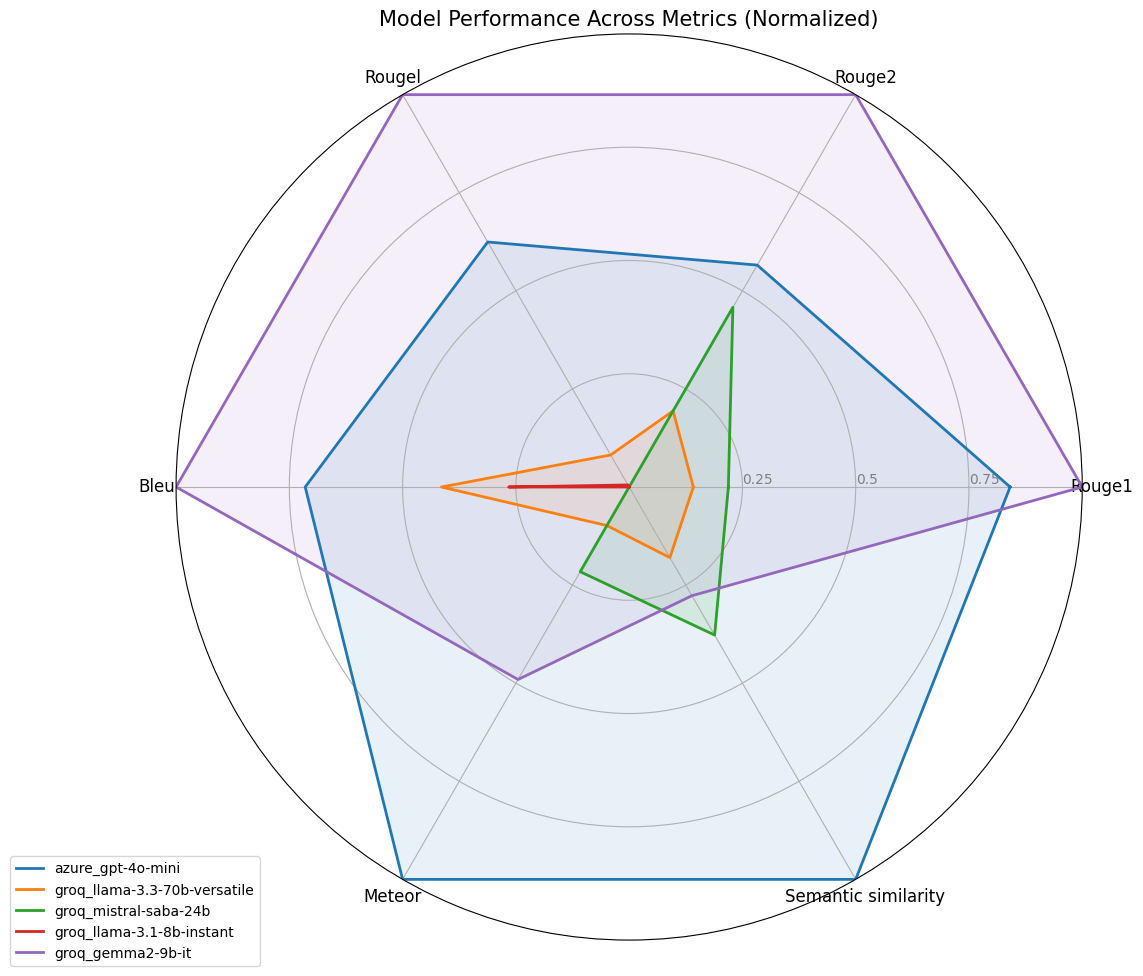

In [21]:
# Create spider plots for individual model strength analysis
def create_radar_chart():
    metrics = ['rouge1', 'rouge2', 'rougeL', 'bleu', 'meteor', 'semantic_similarity']
    
    # Normalize scores to 0-1 range for better visualization
    normalized_scores = {}
    
    for metric in metrics:
        min_val = min(aggregate_results[model][f"{metric}_mean"] for model in aggregate_results)
        max_val = max(aggregate_results[model][f"{metric}_mean"] for model in aggregate_results)
        range_val = max_val - min_val if max_val > min_val else 1
        
        normalized_scores[metric] = {}
        for model in aggregate_results:
            score = aggregate_results[model][f"{metric}_mean"]
            normalized_scores[metric][model] = (score - min_val) / range_val
    
    # Create radar chart
    fig = plt.figure(figsize=(12, 10))
    
    # Number of variables
    categories = [m.capitalize().replace('_', ' ') for m in metrics]
    N = len(categories)
    
    # Create angle for each metric
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]  # Close the loop
    
    # Add subplot
    ax = plt.subplot(111, polar=True)
    
    # Draw one axis per variable and add labels
    plt.xticks(angles[:-1], categories, size=12)
    
    # Draw y-axis labels
    ax.set_rlabel_position(0)
    plt.yticks([0.25, 0.5, 0.75], ["0.25", "0.5", "0.75"], color="grey", size=10)
    plt.ylim(0, 1)
    
    # Plot each model
    for i, model in enumerate(aggregate_results):
        values = [normalized_scores[metric][model] for metric in metrics]
        values += values[:1]  # Close the loop
        
        # Plot values
        ax.plot(angles, values, linewidth=2, linestyle='solid', label=model)
        ax.fill(angles, values, alpha=0.1)
    
    # Add legend
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    plt.title("Model Performance Across Metrics (Normalized)", size=15)
    
    plt.tight_layout()
    plt.savefig(os.path.join(plots_dir, "radar_chart.png"), dpi=300)
    plt.show()

create_radar_chart()